In [40]:
import seaborn as sns
import pandas as pd
# import pandasql as ps
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
# import duckdb
import re

from wa_analyzer.model import TextClustering

clustering = TextClustering()

warnings.filterwarnings("ignore", category=FutureWarning)

In [41]:
# Load configuration and data
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
wa_df = pd.read_parquet(datafile)


And now lets test it on the whatsapp data:

We know the authors, so let's use the labels.

In [42]:
# list unique authors
authors = list(np.unique(wa_df.author))
print(len(authors))

78


In [43]:
def remove_url(text):
    return re.sub(r"^https?:\/\/.*[\r\n]*", "", text)

We take a subset of every author, and join their texts.
Obviously, you can only do this if you know the authors, or at least the claimed authors. Concatenating all texts together will make the data useless. 

In [44]:
# chunk size
# Each author’s text will be split into segments (“chunks”) of 500 characters.
n = 500

# minimum number of parts to include author in corpus
min_parts = 2

# create corpus dictionary with author as key and list of text chunks as values
corpus = {}

for author in authors:

    # concatenate all messages from author into one long string
    subset = wa_df[wa_df.author == author].reset_index()
    # subset.shape

    # print number of messages per author
    print(f'Author {author} has {len(subset)} messages')
    
    # Concatenate all their messages into one long string
    longseq = " ".join(subset.message)
    print(f'Author {author} has {len(longseq)} message length characters')
    # print(f'{author}: {longseq}')

    # chunk everything into n-sized parts
    # Split that long text into fixed-size “chunks”
    parts = [longseq[i : i + n] for i in range(0, len(longseq), n)]
    print(f'Author {author} has {len(parts)} parts of size {n} characters pre-cleaning')

    # clean urls
    parts = [remove_url(chunk) for chunk in parts]
    # print(f'Author {author} has {len(parts)} parts of size {n} characters post-cleaning')
    # print(f'Author {author} has {len(longseq)} message length characters post-cleaning')

    # remove double spaces
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    # print(f'Author {author} has {len(parts)} parts of size {n} characters post-remove double spaces')
    print(f'Author {author} has {len(longseq)} message length characters post-remove double spaces')

    # keep only parts with more than min_parts
    if len(parts) > min_parts:
        corpus[author] = parts
corpus.keys()

Author bejeweled-beluga has 4 messages
Author bejeweled-beluga has 978 message length characters
Author bejeweled-beluga has 2 parts of size 500 characters pre-cleaning
Author bejeweled-beluga has 978 message length characters post-remove double spaces
Author billowy-meerkat has 9 messages
Author billowy-meerkat has 751 message length characters
Author billowy-meerkat has 2 parts of size 500 characters pre-cleaning
Author billowy-meerkat has 751 message length characters post-remove double spaces
Author bold-bison has 82 messages
Author bold-bison has 5587 message length characters
Author bold-bison has 12 parts of size 500 characters pre-cleaning
Author bold-bison has 5587 message length characters post-remove double spaces
Author bouncy-worm has 35 messages
Author bouncy-worm has 1506 message length characters
Author bouncy-worm has 4 parts of size 500 characters pre-cleaning
Author bouncy-worm has 1506 message length characters post-remove double spaces
Author cackling-eland has 106

dict_keys(['bold-bison', 'bouncy-worm', 'cackling-eland', 'captivating-dove', 'carefree-lark', 'cheerful-boar', 'cheerful-mule', 'chuckling-stork', 'coltish-owl', 'cordial-eel', 'dazzling-curlew', 'dazzling-yak', 'dynamic-frog', 'ebullient-mosquito', 'elaborate-jay', 'entertaining-pig', 'ethereal-lapwing', 'eye-catching-hare', 'eye-catching-okapi', 'flexible-platypus', 'freckled-wolverine', 'funny-swallow', 'goofy-tiger', 'happy-beaver', 'hilarious-dogfish', 'intense-toad', 'joyful-okapi', 'kooky-tapir', 'limber-ostrich', 'loony-albatross', 'lustrous-reindeer', 'mind-blowing-kudu', 'multicolored-dogfish', 'pellucid-quelea', 'peppy-rat', 'piebald-rhinoceros', 'quick-chamois', 'radiant-coyote', 'resplendent-aardwolf', 'rollicking-ostrich', 'saturated-whistling duck', 'silky-lapwing', 'snorting-ibex', 'soft-eland', 'splattered-barracuda', 'springy-hare', 'stippled-pig', 'sudsy-eland', 'sudsy-jellyfish', 'sunny-gazelle', 'upbeat-pigeon', 'vivid-rhinoceros', 'waggish-porcupine', 'wispy-rein

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# create document-term matrix with 3-grams
# Create the vectorizer
# Use character-level 3-grams (sequences of 3 characters)
# Analyze text at the character level (not by words).
# Extract character trigrams (sequences of 3 consecutive characters).
# The vectorizer will treat each unique 3-character sequence as a feature (a column in the final matrix).

"""
"text" → trigrams: "tex", "ext"
"banana" → trigrams: "ban", "ana", "nan", "ana"
"""

vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))

# Fit and transform the text chunks
# Combine all text chunks from all authors into a single list
"""
parts is a list of text chunks, e.g.:
["text", "banana"], in our case string chunks of 500 characters!

.fit_transform() does two things:
1. fit — finds all unique trigrams across all chunks (builds the vocabulary).
2. transform — counts how many times each trigram appears in each chunk.

"""

X = vectorizer.fit_transform(parts)

# Convert the sparse matrix to a dense format (if needed)
# Note: This can be memory-intensive for large datasets
X = np.asarray(X.todense())

X.shape # (number of text chunks, number of unique 3-grams) / (23, 2028)

(23, 2028)

2025-10-14 19:58:01.959 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (880, 13675)
2025-10-14 19:58:14.396 | INFO     | wa_analyzer.model:reduce_dims:42 - Using PCA


Text(0.5, 1.0, 'Distinct authors in the WhatsApp dataset')

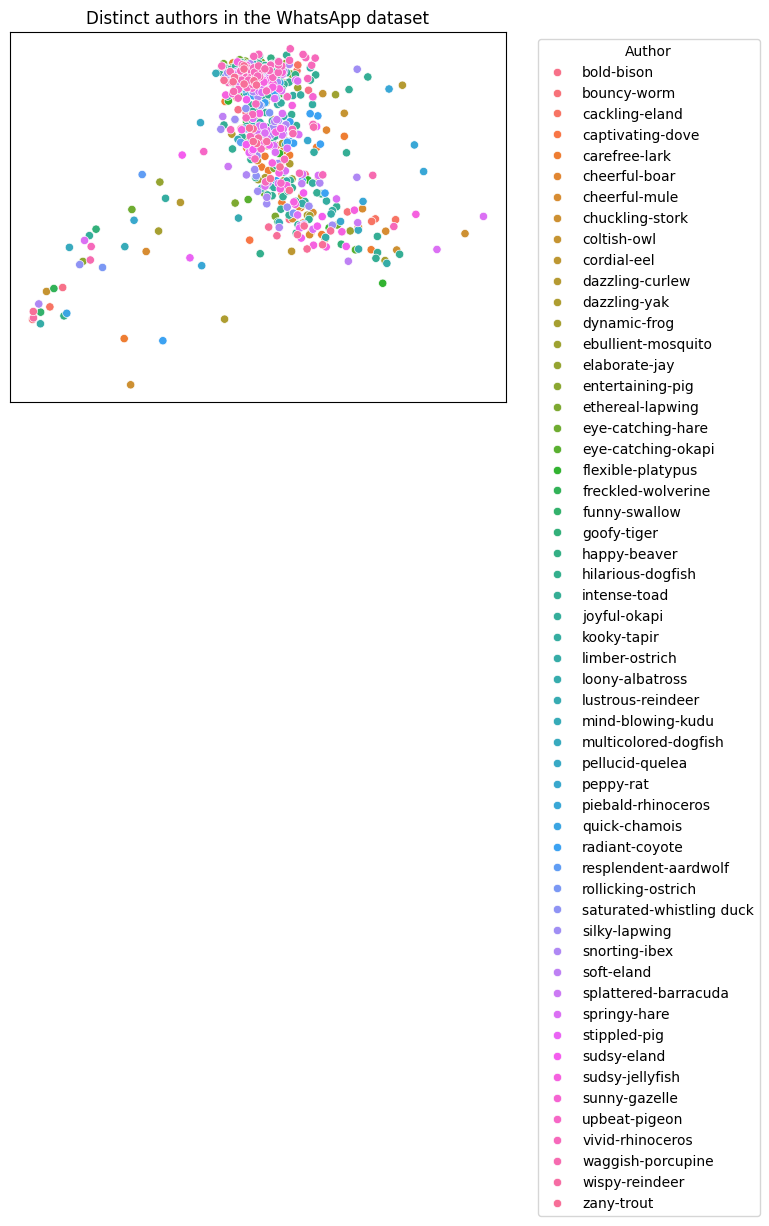

In [48]:
import matplotlib.pyplot as plt

text = [part for text in corpus.values() for part in text]
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
# we set batch to false, because we already batched the data
# clustering(text=text, k=100, labels=wa_labels, batch=False, method="tSNE")
clustering(text=text, k=100, labels=wa_labels, batch=False, method="PCA")

plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset")

PCA visualization of WhatsApp messages from the apartment building looks great.

🧠 What the analysis does

You used character-level trigram PCA to analyze writing patterns across WhatsApp messages from multiple residents in your building.

Each point = one chunk of messages (about 500 characters).

Each color = a different author.

PCA reduces thousands of text features (character trigrams) into two principal components, which capture the largest stylistic variation.

So, the plot visualizes differences in writing style between authors.


📊 What your plot shows

Dense cluster in the center

Most messages overlap heavily in the middle.

Indicates that many residents write in similar styles — short, conversational WhatsApp language (abbreviations, emojis, informal tone) creates little stylistic separation.

A few outliers spread around the edges

These could represent:

Residents with distinctive writing habits (longer sentences, punctuation, formal tone, etc.).

People who write in another language or mix in different scripts.

Outlier chunks with very short or very long messages, or a high density of emojis, URLs, or special characters.

No clear, tight clusters per author

Suggests that PCA alone doesn’t fully separate authors — which is expected for short, casual text.

Writing variation within one person may be larger than variation between people in WhatsApp chats.